## Note: Elasticsearch for Nearest Neighbour Query / Proximity Search

Objective is to demonstrate nearest neighbour search by using geospatial index.


In [176]:
%%capture
%pip install elasticsearch

In [3]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import pandas as pd
import json

Let's load configuration data from a file

In [7]:
from dotenv import dotenv_values
config_filename = 'es_kibana.cfg'
config = dotenv_values(config_filename)
if config['ELASTIC_PASSWORD'] is None:
    print(f"No {config_filename} file not found!")
else:
    ELASTIC_PASSWORD = config['ELASTIC_PASSWORD']


## Connect to Elasticsearch
Let's connect to Elasticsearch

In [8]:
#
client = Elasticsearch([{'host': 'localhost', 'port': 9200, "scheme": "http"}]
                       , basic_auth=("elastic", ELASTIC_PASSWORD)
                       )

Let's print the metadata attached to Elasticsearch client object

In [ ]:
client.info()

In [9]:
answer = client.info()
print(type(answer))

# Custom made; elastic_transport.ObjectApiResponse is a dict
for k in answer.keys():
    if k == 'version':
        print(f"{k} :")
        for k2 in answer[k]:
            print(f"\t{k2} : {answer[k][k2]}")
    else:
        print(f"{k} : {answer[k]}")

<class 'elastic_transport.ObjectApiResponse'>
name : 8bb798e2995b
cluster_name : docker-cluster
cluster_uuid : bvhUZ6w4T2Wv-eDmKDDmBQ
version :
	number : 9.1.5
	build_flavor : default
	build_type : docker
	build_hash : 90ee222e7e0136dd8ddbb34015538f3a00c129b7
	build_date : 2025-10-02T22:07:12.966975992Z
	build_snapshot : False
	lucene_version : 10.2.2
	minimum_wire_compatibility_version : 8.19.0
	minimum_index_compatibility_version : 8.0.0
tagline : You Know, for Search


Test that we can create an index.

In [10]:
response = None
try:
    response = client.indices.create(index="my-index")
    print(response)
except Exception as e:
    print(e)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'my-index'}


Delete an index

In [11]:
response=client.indices.delete(index="my-index", ignore_unavailable=True)
print(response)

{'acknowledged': True}


In [16]:
response=client.indices.delete(index="restaurants_index", ignore_unavailable=True)
print(response)

{'acknowledged': True}


## Create an Index
Let's create restaurants index

In [17]:
columns = ["Field Name","Field Data Type","Notes"]
data = [ {"Field Name":"rid","Field Data Type":"integer","Notes":""},
         {"Field Name":"name","Field Data Type":"text","Notes":"searchable text content, search by name"},
         {"Field Name":"cuisine","Field Data Type":"text","Notes":"searchable text content, search by cuisine"},
         {"Field Name":"location","Field Data Type":"geo_point","Notes":"latitude/longitude coordinates, search by nearby"},
         {"Field Name":"description","Field Data Type":"text","Notes":"searchable text content"},
         ]
df = pd.DataFrame(data=data,columns = columns)
df

,Field Name,Field Data Type,Notes
0,rid,integer,
1,name,text,"searchable text content, search by name"
2,cuisine,text,"searchable text content, search by cuisine"
3,location,geo_point,"latitude/longitude coordinates, search by nearby"
4,description,text,searchable text content


Mapping specifies what an application will store in the index. Restaurant Identifier (restaurant_id) comes from restaurants table.

In [18]:
restaurants_mappings = {
 "properties": {
     "rid" : {
         "type": "integer",
        },
      "name": {
        "type": "text",      ## searchable text content, search by name
      },
      "cuisine": {
        "type": "text",      ## searchable text content, search by cuisine
      },
      "location": {
        "type": "geo_point",  ## latitude/longitude coordinates, search by nearby
      },
      "description": {
        "type": "text",      ## searchable text content
      },
    },
}

Let's create an index by using the mappings.

In [19]:
# Create the index
client.indices.create(index="restaurants_index", mappings=restaurants_mappings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'restaurants_index'})

In [20]:
response = client.indices.get(index="restaurants_index")
print(response)

{'restaurants_index': {'aliases': {}, 'mappings': {'properties': {'cuisine': {'type': 'text'}, 'description': {'type': 'text'}, 'location': {'type': 'geo_point'}, 'name': {'type': 'text'}, 'rid': {'type': 'integer'}}}, 'settings': {'index': {'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}}, 'number_of_shards': '1', 'provided_name': 'restaurants_index', 'creation_date': '1760823852404', 'number_of_replicas': '1', 'uuid': '2C2JVmj3S6WQ3-z0QugWLQ', 'version': {'created': '9033000'}}}}}


## Load data to Elasticsearch index
Let's load restaurants data from CSV file into Pandas Data Frame.

In [21]:
filename="./restaurants.csv"
df = pd.read_csv(filename)
df[:10]

,Name,Lon,Lat
0,Morris Park Bake Shop,-73.856077,40.848447
1,Wendy'S,-73.961704,40.662942
2,Riviera Caterer,-73.982420,40.579505
3,Tov Kosher Kitchen,-73.860115,40.731174
4,Brunos On The Boulevard,-73.880383,40.764312
5,Dj Reynolds Pub And Restaurant,-73.985136,40.767692
6,Wilken'S Fine Food,-73.906851,40.619903
7,Regina Caterers,-74.005289,40.628886
8,Taste The Tropics Ice Cream,-73.948261,40.640827
9,Kosher Island,-74.137729,40.611957


Each row contains the name of restaurant and its location. Let's add Rid column for this exercise.

In [22]:
df['Rid'] = df.index
printdf = df[:10]
print(printdf.to_string(index=False))


                          Name        Lon       Lat  Rid
         Morris Park Bake Shop -73.856077 40.848447    0
                       Wendy'S -73.961704 40.662942    1
               Riviera Caterer -73.982420 40.579505    2
            Tov Kosher Kitchen -73.860115 40.731174    3
       Brunos On The Boulevard -73.880383 40.764312    4
Dj Reynolds Pub And Restaurant -73.985136 40.767692    5
            Wilken'S Fine Food -73.906851 40.619903    6
               Regina Caterers -74.005289 40.628886    7
   Taste The Tropics Ice Cream -73.948261 40.640827    8
                 Kosher Island -74.137729 40.611957    9


Let's prepare a document representing a restaurant records in Elasticsearch.
<br> location follows geo_point syntax. See [Geo_Point specification](https://www.elastic.co/docs/reference/elasticsearch/mapping-reference/geo-point) for details.

In [23]:
rst = {
    "rid": int(df.at[0,"Rid"]),
    "name": df.at[0,"Name"],
    "cuisine": "italian",
    "location": {
        "lat": float("%f" % df.at[0,"Lat"]),
        "lon": float("%f" % df.at[0,"Lon"]),
    },
    "description": "searchable text content",
}
rst

{'rid': 0,
 'name': 'Morris Park Bake Shop',
 'cuisine': 'italian',
 'location': {'lat': 40.848447, 'lon': -73.856077},
 'description': 'searchable text content'}

In [24]:
response = client.index(index="restaurants_index", body=rst)
print(response)

{'_index': 'restaurants_index', '_id': 'JYVI-ZkBAy2C4wOUXlJ0', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1}


## Query by a rid field value
Let's query what we have added/indexed.
<br> The first restaurant record's rid is 0, therefore, it will look for entries having 0 as rid value.

In [25]:
query = {
    'query': {
        'match': {
            'rid': 0
        }
    },
    'size': 10
}
response = client.search(index="restaurants_index", body=query)
print(response)

{'took': 72, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'restaurants_index', '_id': 'JYVI-ZkBAy2C4wOUXlJ0', '_score': 1.0, '_source': {'rid': 0, 'name': 'Morris Park Bake Shop', 'cuisine': 'italian', 'location': {'lat': 40.848447, 'lon': -73.856077}, 'description': 'searchable text content'}}]}}


Response has metadata and matching documents (in _source).

In [26]:
for r in response['hits']['hits']:
    print(f"_index : {r['_index']}")
    print(f"_id    : {r['_id']}")
    print(f"_score : {r['_score']}")
    print( "source : ")
    for k in r['_source'].keys():
        print(f"\t{k} : {r['_source'][k]}")

_index : restaurants_index
_id    : JYVI-ZkBAy2C4wOUXlJ0
_score : 1.0
source : 
	rid : 0
	name : Morris Park Bake Shop
	cuisine : italian
	location : {'lat': 40.848447, 'lon': -73.856077}
	description : searchable text content


Add all data in dataframe to index in Elasticsearch.

In [27]:
df.iloc[-1]

Name    Capital Grille
Lon         -73.974723
Lat          40.751244
Rid               4999
Name: 4999, dtype: object

In [28]:
df[-3:]

,Name,Lon,Lat,Rid
4997,Ellen Deli & Grocery,-74.007810,40.725708,4997
4998,Crepes On Columbus,-73.961831,40.801052,4998
4999,Capital Grille,-73.974723,40.751244,4999


Let's add cuisine field randomly.
<br>Sampled from [List Of Cuisines](https://en.wikipedia.org/wiki/List_of_cuisines)

In [29]:
import random

cuisine = ['italian', 'chinese', 'french', 'zambian', 'egyptian', 'canadian', 'mexican', 'vietnamese', 'cajun', 'korean', 'thai', 'brazilian','colombian','peruvian','ecuadorian', 'japanese','indian','malaysian','russian', 'indonesian']

for i in range(df.shape[0]):
    df.at[i,'Cuisine'] = cuisine[random.randint(0,len(cuisine)-1)]
df[-4:]

,Name,Lon,Lat,Rid,Cuisine
4996,Wagner College - Hawk' Nest,-74.092853,40.615121,4996,russian
4997,Ellen Deli & Grocery,-74.007810,40.725708,4997,malaysian
4998,Crepes On Columbus,-73.961831,40.801052,4998,malaysian
4999,Capital Grille,-73.974723,40.751244,4999,mexican


Because the original data does not have 'cuisine' column, it assigned a random value from cuisine list.

In [30]:
import seaborn as sns

<Axes: xlabel='Count', ylabel='Cuisine'>

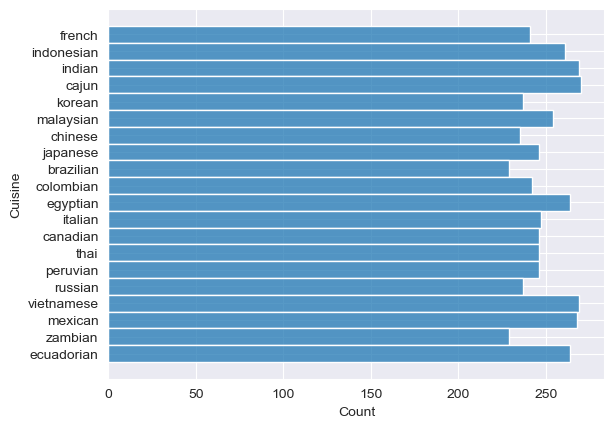

In [32]:
sns.histplot(data=df, y="Cuisine")

In [40]:
def restaurants_doc_builder(r):
    rst = {
        "rid": int(r["rid"]),
        "name": r["name"],
    }
    return rst

def restaurants_index_add(r):
    doc = {
        "rid": int(r["Rid"]),
        "name": r["Name"],
        "cuisine": r["Cuisine"],
        "location": {
            "lat": float("%f" % r["Lat"]),
            "lon": float("%f" % r["Lon"]),
        },
        "description": "searchable text content",
    }
    response = client.index(index="restaurants_index", body=doc)
    return response['result']



In [36]:
from tabulate import tabulate

In [38]:
df3 = df[1:10]
table_df3 = tabulate(
    df3,
    headers=["Name", "Lon", "Lat", "Rid", "CUisine"],
    tablefmt="grid"
)
print(table_df3)

+----+--------------------------------+----------+---------+-------+------------+
|    | Name                           |      Lon |     Lat |   Rid | CUisine    |
+====+================================+==========+=========+=======+============+
|  1 | Wendy'S                        | -73.9617 | 40.6629 |     1 | indonesian |
+----+--------------------------------+----------+---------+-------+------------+
|  2 | Riviera Caterer                | -73.9824 | 40.5795 |     2 | indian     |
+----+--------------------------------+----------+---------+-------+------------+
|  3 | Tov Kosher Kitchen             | -73.8601 | 40.7312 |     3 | cajun      |
+----+--------------------------------+----------+---------+-------+------------+
|  4 | Brunos On The Boulevard        | -73.8804 | 40.7643 |     4 | cajun      |
+----+--------------------------------+----------+---------+-------+------------+
|  5 | Dj Reynolds Pub And Restaurant | -73.9851 | 40.7677 |     5 | korean     |
+----+----------

Let's add each restaurant information to index.
<br> It will track the status of each add operation in df3['Result'] column.
<br> For production, bulk insert is recommended.

In [41]:

df3['Result'] = df3.apply(restaurants_index_add, axis=1)
df3

C:\Users\timuc\AppData\Local\Temp\ipykernel_71448\4286227349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Result'] = df3.apply(restaurants_index_add, axis=1)


,Name,Lon,Lat,Rid,Cuisine,Result
1,Wendy'S,-73.961704,40.662942,1,indonesian,created
2,Riviera Caterer,-73.982420,40.579505,2,indian,created
3,Tov Kosher Kitchen,-73.860115,40.731174,3,cajun,created
4,Brunos On The Boulevard,-73.880383,40.764312,4,cajun,created
5,Dj Reynolds Pub And Restaurant,-73.985136,40.767692,5,korean,created
6,Wilken'S Fine Food,-73.906851,40.619903,6,malaysian,created
7,Regina Caterers,-74.005289,40.628886,7,indian,created
8,Taste The Tropics Ice Cream,-73.948261,40.640827,8,chinese,created
9,Kosher Island,-74.137729,40.611957,9,japanese,created


Helper function to print the response cleanly.

In [42]:
# response['hits']['hits']
def print_es_response_hits_hits(response):

    for r in response:
        print("========================")
        print(f"_index : {r['_index']}")
        print(f"_id    : {r['_id']}")
        print(f"_score : {r['_score']}")
        print("source : ")
        for k in r['_source'].keys():
            print(f"\t{k} : {r['_source'][k]}")

### Range Query
Let's retrive records whose rid >= 0 and rid<= 10

In [150]:
# Range Query
query = {
    'query': {
        'range': {
            'rid': {
                'gte': 0,
                'lte': 10
            }
        }
    },
    'size': 10
}
response = client.search(index="restaurants_index", body=query)
print(response)

{'took': 8, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'restaurants_index', '_id': 'GoUM85kBAy2C4wOUm1IA', '_score': 1.0, '_source': {'rid': 0, 'name': 'Morris Park Bake Shop', 'cuisine': 'italian', 'location': {'lat': 40.848447, 'lon': -73.856077}, 'description': 'searchable text content'}}, {'_index': 'restaurants_index', '_id': 'G4VQ85kBAy2C4wOUU1IZ', '_score': 1.0, '_source': {'rid': 1, 'name': "Wendy'S", 'cuisine': 'vietnamese', 'location': {'lat': 40.662942, 'lon': -73.961704}, 'description': 'searchable text content'}}, {'_index': 'restaurants_index', '_id': 'HIVQ85kBAy2C4wOUU1Jn', '_score': 1.0, '_source': {'rid': 2, 'name': 'Riviera Caterer', 'cuisine': 'korean', 'location': {'lat': 40.579505, 'lon': -73.98242}, 'description': 'searchable text content'}}, {'_index': 'restaurants_index', '_id': 'HYVQ85kBAy2C4wOUU1Kr', '_score': 1.0, '_source': {

Return message contains metadata and matching rows. The above included to demonstrate what is actually transmitted on the wire. For production, consider compression.
<br> Query response is in respose['hits']['hits'] list of dict thst has "_source" key

In [43]:
print_es_response_hits_hits(response['hits']['hits'])

_index : restaurants_index
_id    : JYVI-ZkBAy2C4wOUXlJ0
_score : 1.0
source : 
	rid : 0
	name : Morris Park Bake Shop
	cuisine : italian
	location : {'lat': 40.848447, 'lon': -73.856077}
	description : searchable text content


## Nearest Neighbours Query
Let's prep NN query with geo_distance element.
 1. **distance** specifies the radius of a circle
 1. **location** specifies the center of a circle

In [46]:
NNQ_LON=-73.961704
NNQ_LAT= 40.662942
NNQ_RADIUS = 160

query = {
    'query': {
        'bool': {
            'filter': {
                'geo_distance': {
                    "distance": "10km",
                    "location": {
                    "lat": float(f"{NNQ_LAT}"),
                    "lon": float(f"{NNQ_LON}"),
                    }
                }
            }
        }
    },
    "sort":[ {"_score": {"order": "desc"}}],
    'size': 10
}
print(query)
print(json.dumps(query, indent=2))


{'query': {'bool': {'filter': {'geo_distance': {'distance': '10km', 'location': {'lat': 40.662942, 'lon': -73.961704}}}}}, 'sort': [{'_score': {'order': 'desc'}}], 'size': 10}
{
  "query": {
    "bool": {
      "filter": {
        "geo_distance": {
          "distance": "10km",
          "location": {
            "lat": 40.662942,
            "lon": -73.961704
          }
        }
      }
    }
  },
  "sort": [
    {
      "_score": {
        "order": "desc"
      }
    }
  ],
  "size": 10
}


query specification also includes sort and size elements.
 1. **sort** specifies which field sorting algorithm should use.
 1. **size** specifies the number of rows in query response for pagination. For production, please see Elasticsearch DSL with cursor based efficient pagination.

In [47]:
response = client.search(index="restaurants_index", body=query)
print(response)

{'took': 22, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 5, 'relation': 'eq'}, 'max_score': 0.0, 'hits': [{'_index': 'restaurants_index', '_id': 'JoVT-ZkBAy2C4wOUZVIE', '_score': 0.0, '_source': {'rid': 1, 'name': "Wendy'S", 'cuisine': 'indonesian', 'location': {'lat': 40.662942, 'lon': -73.961704}, 'description': 'searchable text content'}}, {'_index': 'restaurants_index', '_id': 'J4VT-ZkBAy2C4wOUZVJS', '_score': 0.0, '_source': {'rid': 2, 'name': 'Riviera Caterer', 'cuisine': 'indian', 'location': {'lat': 40.579505, 'lon': -73.98242}, 'description': 'searchable text content'}}, {'_index': 'restaurants_index', '_id': 'K4VT-ZkBAy2C4wOUZlIt', '_score': 0.0, '_source': {'rid': 6, 'name': "Wilken'S Fine Food", 'cuisine': 'malaysian', 'location': {'lat': 40.619903, 'lon': -73.906851}, 'description': 'searchable text content'}}, {'_index': 'restaurants_index', '_id': 'LIVT-ZkBAy2C4wOUZlJh', '_score': 0.0, '_source': {'

In [50]:
print(f"There are {response['hits']['total']['value']} matching records!")

There are 5 matching records!


In [51]:
print(json.dumps(dict(response), indent=2))

{
  "took": 22,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 5,
      "relation": "eq"
    },
    "max_score": 0.0,
    "hits": [
      {
        "_index": "restaurants_index",
        "_id": "JoVT-ZkBAy2C4wOUZVIE",
        "_score": 0.0,
        "_source": {
          "rid": 1,
          "name": "Wendy'S",
          "cuisine": "indonesian",
          "location": {
            "lat": 40.662942,
            "lon": -73.961704
          },
          "description": "searchable text content"
        }
      },
      {
        "_index": "restaurants_index",
        "_id": "J4VT-ZkBAy2C4wOUZVJS",
        "_score": 0.0,
        "_source": {
          "rid": 2,
          "name": "Riviera Caterer",
          "cuisine": "indian",
          "location": {
            "lat": 40.579505,
            "lon": -73.98242
          },
          "description": "searchable text content"
        }
    

In [52]:
print_es_response_hits_hits(response['hits']['hits'])

_index : restaurants_index
_id    : JoVT-ZkBAy2C4wOUZVIE
_score : 0.0
source : 
	rid : 1
	name : Wendy'S
	cuisine : indonesian
	location : {'lat': 40.662942, 'lon': -73.961704}
	description : searchable text content
_index : restaurants_index
_id    : J4VT-ZkBAy2C4wOUZVJS
_score : 0.0
source : 
	rid : 2
	name : Riviera Caterer
	cuisine : indian
	location : {'lat': 40.579505, 'lon': -73.98242}
	description : searchable text content
_index : restaurants_index
_id    : K4VT-ZkBAy2C4wOUZlIt
_score : 0.0
source : 
	rid : 6
	name : Wilken'S Fine Food
	cuisine : malaysian
	location : {'lat': 40.619903, 'lon': -73.906851}
	description : searchable text content
_index : restaurants_index
_id    : LIVT-ZkBAy2C4wOUZlJh
_score : 0.0
source : 
	rid : 7
	name : Regina Caterers
	cuisine : indian
	location : {'lat': 40.628886, 'lon': -74.005289}
	description : searchable text content
_index : restaurants_index
_id    : LYVT-ZkBAy2C4wOUZlKX
_score : 0.0
source : 
	rid : 8
	name : Taste The Tropics Ice 

In [53]:
# Helper
def get_data_frame(r_src, r_score):
    my_row = {
        'rid': r_src['rid'],
        'name': r_src['name'] ,
        'cuisine': r_src['cuisine'],
        'location_lat': r_src['location']['lat'],
        'location_lon': r_src['location']['lon'],
        'description': r_src['description'],
        '_score': r_score,
    }
    return dict(my_row)


columns=['rid', 'name', 'cuisine', 'location_lat', 'location_lon', 'description']
df_qresponse = pd.DataFrame(columns=columns)
for r in response['hits']['hits']:
    new_row = pd.DataFrame.from_dict(data=[get_data_frame(r['_source'],r['_score'])], orient='columns')
    df_qresponse = pd.concat([df_qresponse, new_row], ignore_index=True)

df_qresponse

C:\Users\timuc\AppData\Local\Temp\ipykernel_71448\361358445.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_qresponse = pd.concat([df_qresponse, new_row], ignore_index=True)


,rid,name,cuisine,location_lat,location_lon,description,_score
0,1,Wendy'S,indonesian,40.662942,-73.961704,searchable text content,0.0
1,2,Riviera Caterer,indian,40.579505,-73.982420,searchable text content,0.0
2,6,Wilken'S Fine Food,malaysian,40.619903,-73.906851,searchable text content,0.0
3,7,Regina Caterers,indian,40.628886,-74.005289,searchable text content,0.0
4,8,Taste The Tropics Ice Cream,chinese,40.640827,-73.948261,searchable text content,0.0


In [74]:
# Helper
def build_query_response_df(response_hits_hits):
    columns=['rid', 'name', 'cuisine', 'location_lat', 'location_lon', 'description']
    qresponse = pd.DataFrame(columns=columns)
    for r in response_hits_hits:
        new_row = pd.DataFrame.from_dict(data=[get_data_frame(r['_source'],r['_score'])], orient='columns')
        qresponse = pd.concat([df_qresponse, new_row], ignore_index=True)
    return qresponse


In [64]:
table_qres = tabulate(
    build_query_response_df(response['hits']['hits']),
    headers=["Rid","Name", "Cuisine","Lon", "Lat", "Description", "_score"],
    tablefmt="grid"
)
print(table_qres)

+----+-------+-----------------------------+------------+---------+----------+-------------------------+----------+
|    |   Rid | Name                        | Cuisine    |     Lon |      Lat | Description             |   _score |
+====+=======+=============================+============+=========+==========+=========================+==========+
|  0 |     1 | Wendy'S                     | indonesian | 40.6629 | -73.9617 | searchable text content |   0      |
+----+-------+-----------------------------+------------+---------+----------+-------------------------+----------+
|  1 |     2 | Riviera Caterer             | indian     | 40.5795 | -73.9824 | searchable text content |   0      |
+----+-------+-----------------------------+------------+---------+----------+-------------------------+----------+
|  2 |     6 | Wilken'S Fine Food          | malaysian  | 40.6199 | -73.9069 | searchable text content |   0      |
+----+-------+-----------------------------+------------+---------+-----

Let's search by cuisine

In [65]:
query = {
    'query': {
        'bool': {
            "must": [
                {"match": {"cuisine": "indian"}},
            ]
        }
    },
    "sort": [{"_score": {"order": "desc"}}],
    'size': 10
}

print(json.dumps(dict(query), indent=2))

{
  "query": {
    "bool": {
      "must": [
        {
          "match": {
            "cuisine": "indian"
          }
        }
      ]
    }
  },
  "sort": [
    {
      "_score": {
        "order": "desc"
      }
    }
  ],
  "size": 10
}


In [72]:
response = client.search(index="restaurants_index", body=query)
print_es_response_hits_hits(response['hits']['hits'])

_index : restaurants_index
_id    : J4VT-ZkBAy2C4wOUZVJS
_score : 1.4816045
source : 
	rid : 2
	name : Riviera Caterer
	cuisine : indian
	location : {'lat': 40.579505, 'lon': -73.98242}
	description : searchable text content
_index : restaurants_index
_id    : LIVT-ZkBAy2C4wOUZlJh
_score : 1.4816045
source : 
	rid : 7
	name : Regina Caterers
	cuisine : indian
	location : {'lat': 40.628886, 'lon': -74.005289}
	description : searchable text content


In [84]:
list_dict = []
for r in response['hits']['hits']:
    a_dictionary = dict(r['_source'])
    list_dict.append(a_dictionary)

df_query_results = pd.DataFrame.from_dict(data=list_dict, orient='columns')
table_qres = tabulate(
    df_query_results,
    headers=["Rid","Name", "Cuisine","Location", "Description"],
    tablefmt="grid"
)
print(table_qres)

+----+-------+-----------------+-----------+---------------------------------------+-------------------------+
|    |   Rid | Name            | Cuisine   | Location                              | Description             |
+====+=======+=================+===========+=======================================+=========================+
|  0 |     2 | Riviera Caterer | indian    | {'lat': 40.579505, 'lon': -73.98242}  | searchable text content |
+----+-------+-----------------+-----------+---------------------------------------+-------------------------+
|  1 |     7 | Regina Caterers | indian    | {'lat': 40.628886, 'lon': -74.005289} | searchable text content |
+----+-------+-----------------+-----------+---------------------------------------+-------------------------+


## Query NN and Cuisine
Example: Find restaurants serving indian cuisine within 10 km.

In [80]:
query = {
    'query': {
        'bool': {
            "must": [
                {"match": {"cuisine": "indian"}},
                {"geo_distance": {
                    "distance": "10km",
                    "location": {
                        "lat": float(f"{NNQ_LAT}"),
                        "lon": float(f"{NNQ_LON}"),
                    }
                }
                },
            ]
        }
    },
    "sort": [{"_score": {"order": "desc"}}],
    'size': 10
}

print(json.dumps(dict(query), indent=2))

{
  "query": {
    "bool": {
      "must": [
        {
          "match": {
            "cuisine": "indian"
          }
        },
        {
          "geo_distance": {
            "distance": "10km",
            "location": {
              "lat": 40.662942,
              "lon": -73.961704
            }
          }
        }
      ]
    }
  },
  "sort": [
    {
      "_score": {
        "order": "desc"
      }
    }
  ],
  "size": 10
}


In [ ]:
response = client.search(index="restaurants_index", body=query)
print_es_response_hits_hits(response['hits']['hits'])

We submitted this query as one query to Elasticsearch.

In [85]:
list_dict = []
for r in response['hits']['hits']:
    a_dictionary = dict(r['_source'])
    list_dict.append(a_dictionary)

df_query_results = pd.DataFrame.from_dict(data=list_dict, orient='columns')
df_query_results

,rid,name,cuisine,location,description
0,2,Riviera Caterer,indian,"{'lat': 40.579505, 'lon': -73.98242}",searchable text content
1,7,Regina Caterers,indian,"{'lat': 40.628886, 'lon': -74.005289}",searchable text content


## Summary
This notebook demonstrated usage of geospatial index and keyword index in Elasticsearch.

<br> System is able to retrieve restaurants based on the location and cuisine by using one query.

<br> Possibilities
 - Include semantic search over Description field.
 - Include ratings as another filter criteria.

<br> Elasticsearch is capable of fulfilling wide range of queries.


## Appendix

### Bulk Index

In [ ]:

operation = []

client.bulk(operation)

### Elasticsearch DSL


### DSL

https://www.elastic.co/docs/reference/elasticsearch/clients/python/configuration
https://www.elastic.co/docs/reference/elasticsearch/mapping-reference/geo-point